In [1]:
import os
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from PIL import Image

from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from helper import *
from models import *
from dataset import SolarTrackerDataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [2]:
TRAIN_FRAC = 0.8
VAL_FRAC = 0.1
SPLIT_STRATEGTY = "random"
START_IMAGE_IDX = 62 # Starting index for loading images for viz from val datasets
NUM_IMAGES = 5 # Number of images to visualize during inference


MODEL_ARCHITECTURE = "unet" # unet or convnext
MODEL_NAME = "deeplabv3" # unet, deeplabv3, convnext
MODEL_ENCODER = "resnet50" # resnet34, resnet50, convnext_tiny 
CHECKPOINT_PATH = "../checkpoints/deeplabv3_data_split_random_resnet50.pth"

### Data Preparation

In [3]:
metadata = "../metadata/tiles_index.csv"
df = pd.read_csv(metadata)

In [4]:
image_path = df['image_path'].tolist()
label_path = df['label_path'].tolist()

image_paths = df['image_path'].tolist()
label_paths = df['label_path'].tolist()

split = DataSplitStrategy()
if SPLIT_STRATEGTY == "simple":
    _, _, test = split.simple_split(image_paths=image_paths,
                                    label_paths=label_paths,
                                    train_frac=TRAIN_FRAC,
                                    val_frac=VAL_FRAC)
elif SPLIT_STRATEGTY == "random":
    _, _, test = split.random_split(image_paths=image_paths,
                                    label_paths=label_paths,
                                    train_frac=TRAIN_FRAC,
                                    val_frac=VAL_FRAC)
else:
    raise ValueError("Invalid split strategy. Choose either 'simple' or 'random'.")


test_image_path, test_label_path = test

In [5]:
test_dataset = SolarTrackerDataset(img_paths=test_image_path, mask_paths=test_label_path)

test_dataloader = DataLoader(test_dataset,
                            batch_size=16,
                            shuffle=False,
                            num_workers=4,
                            pin_memory=True)

In [6]:
def evaluate_model(model, loader, threshold=0.5):
    
    model.eval()

    iou_total = 0
    dice_total = 0
    precision_total = 0
    recall_total = 0
    f1_total = 0
    n = 0

    metrics = CVMetrics()
    with torch.no_grad():
        for idx, images, masks in loader:
            images = images.permute(0, 3, 1, 2).to(device)
            masks = masks.unsqueeze(1).to(device)
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            pred_masks = (probs > threshold).float()

            iou = metrics.compute_iou(pred_masks, masks)
            dice = metrics.compute_dice(pred_masks, masks)
            precision, recall, f1 = metrics.compute_precision_recall_f1(pred_masks, masks)

            iou_total += iou.item()
            dice_total += dice.item()
            precision_total += precision.item()
            recall_total += recall.item()
            f1_total += f1.item()
            n += 1
    
    return {
        "IoU": iou_total / n,
        "Dice": dice_total / n,
        "Precision": precision_total / n,
        "Recall": recall_total / n,
        "F1": f1_total / n,
    }

In [7]:
if MODEL_ARCHITECTURE == "unet":
    model = get_segmentation_model(model_name=MODEL_NAME, model_encoder=MODEL_ENCODER)
elif MODEL_ARCHITECTURE == "convnext":
    model = ConvNeXtModel(backbone_name="convnext_tiny", pretrained=True, num_classes=1)
else:
    raise ValueError(f"Unsupported model architecture: {MODEL_ARCHITECTURE}")

model = model.to(device)


model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.eval()

result = evaluate_model(model, test_dataloader)
print("Evaluation Results:", result)

Evaluation Results: {'IoU': 0.526280152797699, 'Dice': 0.688685941696167, 'Precision': 0.6884033441543579, 'Recall': 0.6923705101013183, 'F1': 0.6886854529380798}


In [8]:
def evaluate_model_geometric(model, loader, threshold=0.5):
    
    model.eval()
    gt_masks = []
    pred_masks = []
    gt_images = []
    with torch.no_grad():
        for idx, images, masks in loader:
            images = images.permute(0, 3, 1, 2).to(device)
            masks = masks.unsqueeze(1).to(device)
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            # converting masks from (N, 1, H, W) to (N, H, W)
            preds = preds.squeeze(1)
            masks = masks.squeeze(1)
            
            pred_masks.append(preds.cpu())
            gt_masks.append(masks.cpu())
            gt_images.append(images.cpu())
            

    pred_masks = torch.cat(pred_masks, axis=0)
    gt_masks = torch.cat(gt_masks, axis=0)
    gt_images = torch.cat(gt_images, axis=0)

    return pred_masks, gt_masks, gt_images

In [9]:
pred_masks, gt_masks, gt_images = evaluate_model_geometric(model, test_dataloader)

pred_mask = pred_masks[0].cpu().numpy()
gt_mask = gt_masks[0].cpu().numpy()

metrics = GeometricMetrics()

results = {}
avg_perp_distance_err = 0.0
avg_angular_err = 0.0
avg_row_precision = 0.0
avg_row_recall = 0.0
avg_row_f1 = 0.0

total_samples = pred_masks.shape[0]

for i in range(total_samples):
    pred_mask = pred_masks[i].cpu().numpy()
    gt_mask = gt_masks[i].cpu().numpy()

    err_metric = metrics.evaluate_centerlines_pixel(pred_mask, gt_mask,
                                        dist_thresh=5,
                                        angle_thresh=5)

    avg_perp_distance_err += err_metric["Mean Perpendicular Distance"]
    avg_angular_err += err_metric["Mean Angular Error"]
    avg_row_precision += err_metric["Row Precision"]
    avg_row_recall += err_metric["Row Recall"]
    avg_row_f1 += err_metric["Row F1"]

results["avg_perpendicular_distance_error"] = avg_perp_distance_err / total_samples
results["avg_angular_error"] = avg_angular_err / total_samples
results["avg_row_precision"] = avg_row_precision / total_samples
results["avg_row_recall"] = avg_row_recall / total_samples
results["avg_row_f1"] = avg_row_f1 / total_samples

for k, v in results.items():
    print(f"{k}: {v:.4f}")


avg_perpendicular_distance_error: 1.6179
avg_angular_error: 0.3890
avg_row_precision: 0.5523
avg_row_recall: 0.5735
avg_row_f1: 0.5593


### Visualizing Predictions

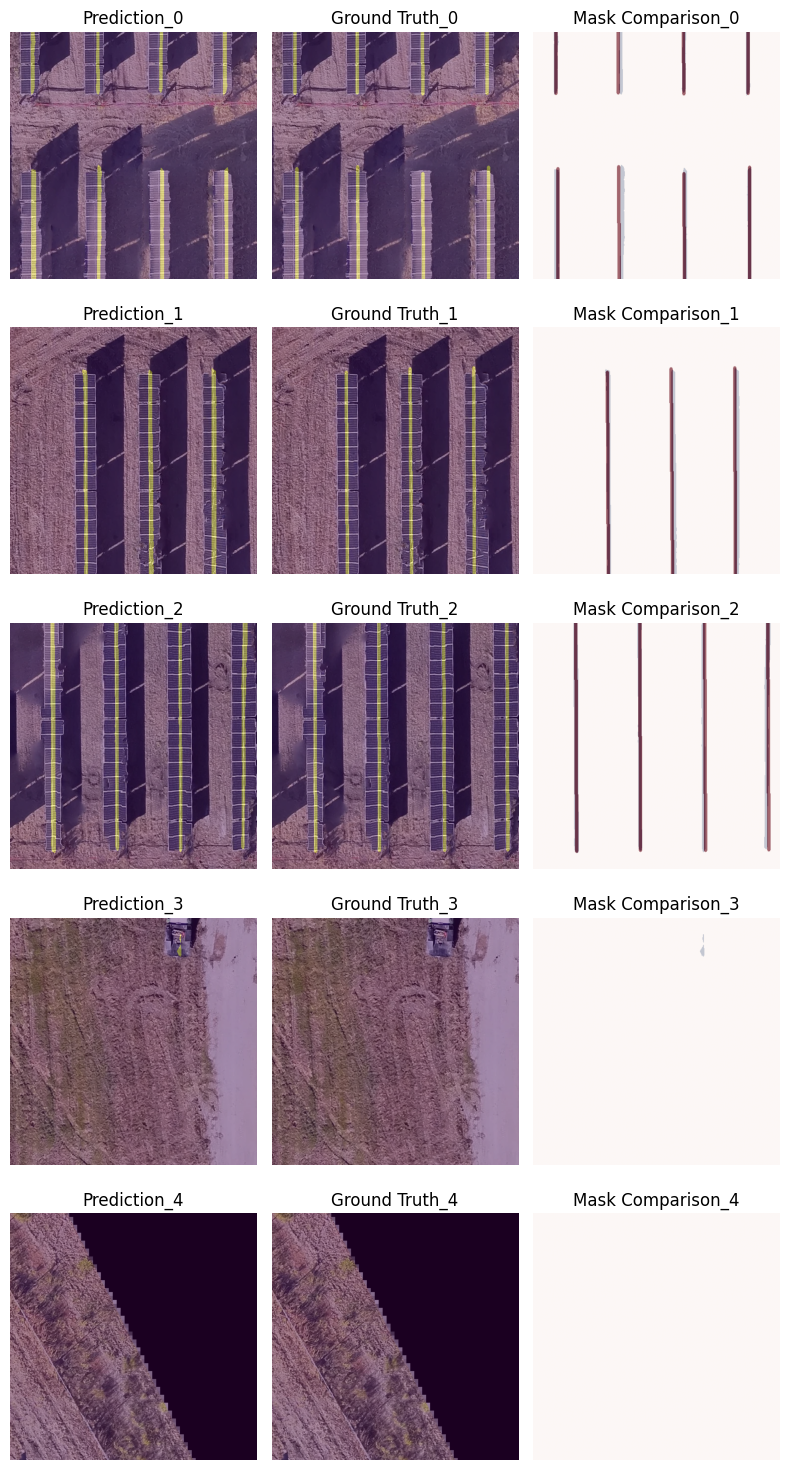

In [10]:
if START_IMAGE_IDX + NUM_IMAGES > pred_masks.shape[0]:
    START_IMAGE_IDX = 0
    NUM_IMAGES = min(START_IMAGE_IDX + NUM_IMAGES, pred_masks.shape[0])
    
pred_masks = pred_masks[START_IMAGE_IDX:START_IMAGE_IDX+NUM_IMAGES]
gt_masks = gt_masks[START_IMAGE_IDX:START_IMAGE_IDX+NUM_IMAGES]
gt_images = gt_images[START_IMAGE_IDX:START_IMAGE_IDX+NUM_IMAGES] 

plot_preds_vs_gt(pred_masks, gt_masks, gt_images, num_images=NUM_IMAGES)